# Chapter 17: Interpreting a process behavior chart

For additional context see chapter 17 of [The Virus of Variation & Process Behavior Charts: A Guide for the Perplexed](https://www.brokenquality.com/book).

In [1]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline

## Get sales data

In [51]:
# Sales dataset url
sales_dataset_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation-and-pbcs/refs/heads/main/data/17-sales-by-region-data.csv'

# Get data
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
sales_df = get_data(sales_dataset_url)

# Make 'Year' column dtype string
sales_df['Month'] = sales_df['Month'].astype('string')
sales_df.head()

,Month,East Region,West Region
0,Jan,10.7,6.9
1,Feb,13.0,11.3
2,Mar,11.4,9.3
3,Apr,11.5,9.8
4,May,12.5,18.7


## Get Vienna General month data

In [53]:
# Vienna General dataset url
vienna_df = get_data(vienna_url)

# Calculate death-to-birth ratio
vienna_df['Death-to-Birth Ratio'] = round((vienna_df['Deaths']/vienna_df['Births']).mul(100),1)
# Calculate the average moving range
vienna_df['Moving Ranges'] = abs(vienna_df['Death-to-Birth Ratio'].diff())

# Add 'ShortMonthYear' column
vienna_df['ShortMonthYear'] = (vienna_df['Month']
                               .apply(lambda x: x[0:3]) + '-' + vienna_df['Year']
                               .apply(lambda x: str(x)[-2:])
                               .astype('string')
                              )
vienna_df

,MonthYear,Year,Month,Births,Deaths,Death-to-Birth Ratio,Moving Ranges,ShortMonthYear
0,January 1841,1841,January,254.0,37.0,14.6,NaN,Jan-41
1,February 1841,1841,February,239.0,18.0,7.5,7.1,Feb-41
2,March 1841,1841,March,277.0,12.0,4.3,3.2,Mar-41
3,April 1841,1841,April,255.0,4.0,1.6,2.7,Apr-41
4,May 1841,1841,May,255.0,2.0,0.8,0.8,May-41
...,...,...,...,...,...,...,...,...
94,November 1848,1848,November,310.0,9.0,2.9,0.6,Nov-48
95,December 1848,1848,December,373.0,5.0,1.3,1.6,Dec-48
96,January 1849,1849,January,403.0,9.0,2.2,0.9,Jan-49
97,February 1849,1849,February,389.0,12.0,3.1,0.9,Feb-49


### Split the dataframe by region

In [12]:
# Split dataframe two dataframes
df_east = sales_df[['Month', 'East Region']].copy()
df_west = sales_df[['Month', 'West Region']].copy()

# Rename the columns for clarity (optional)
df_east.columns = ['Month', 'Sales']
df_west.columns = ['Month', 'Sales']

# Create list of dataframes
df_list = [df_east, df_west]
plot_label_names = ['East Region','West Region']

## Fig 17.2: XmR Chart comparison of sales data

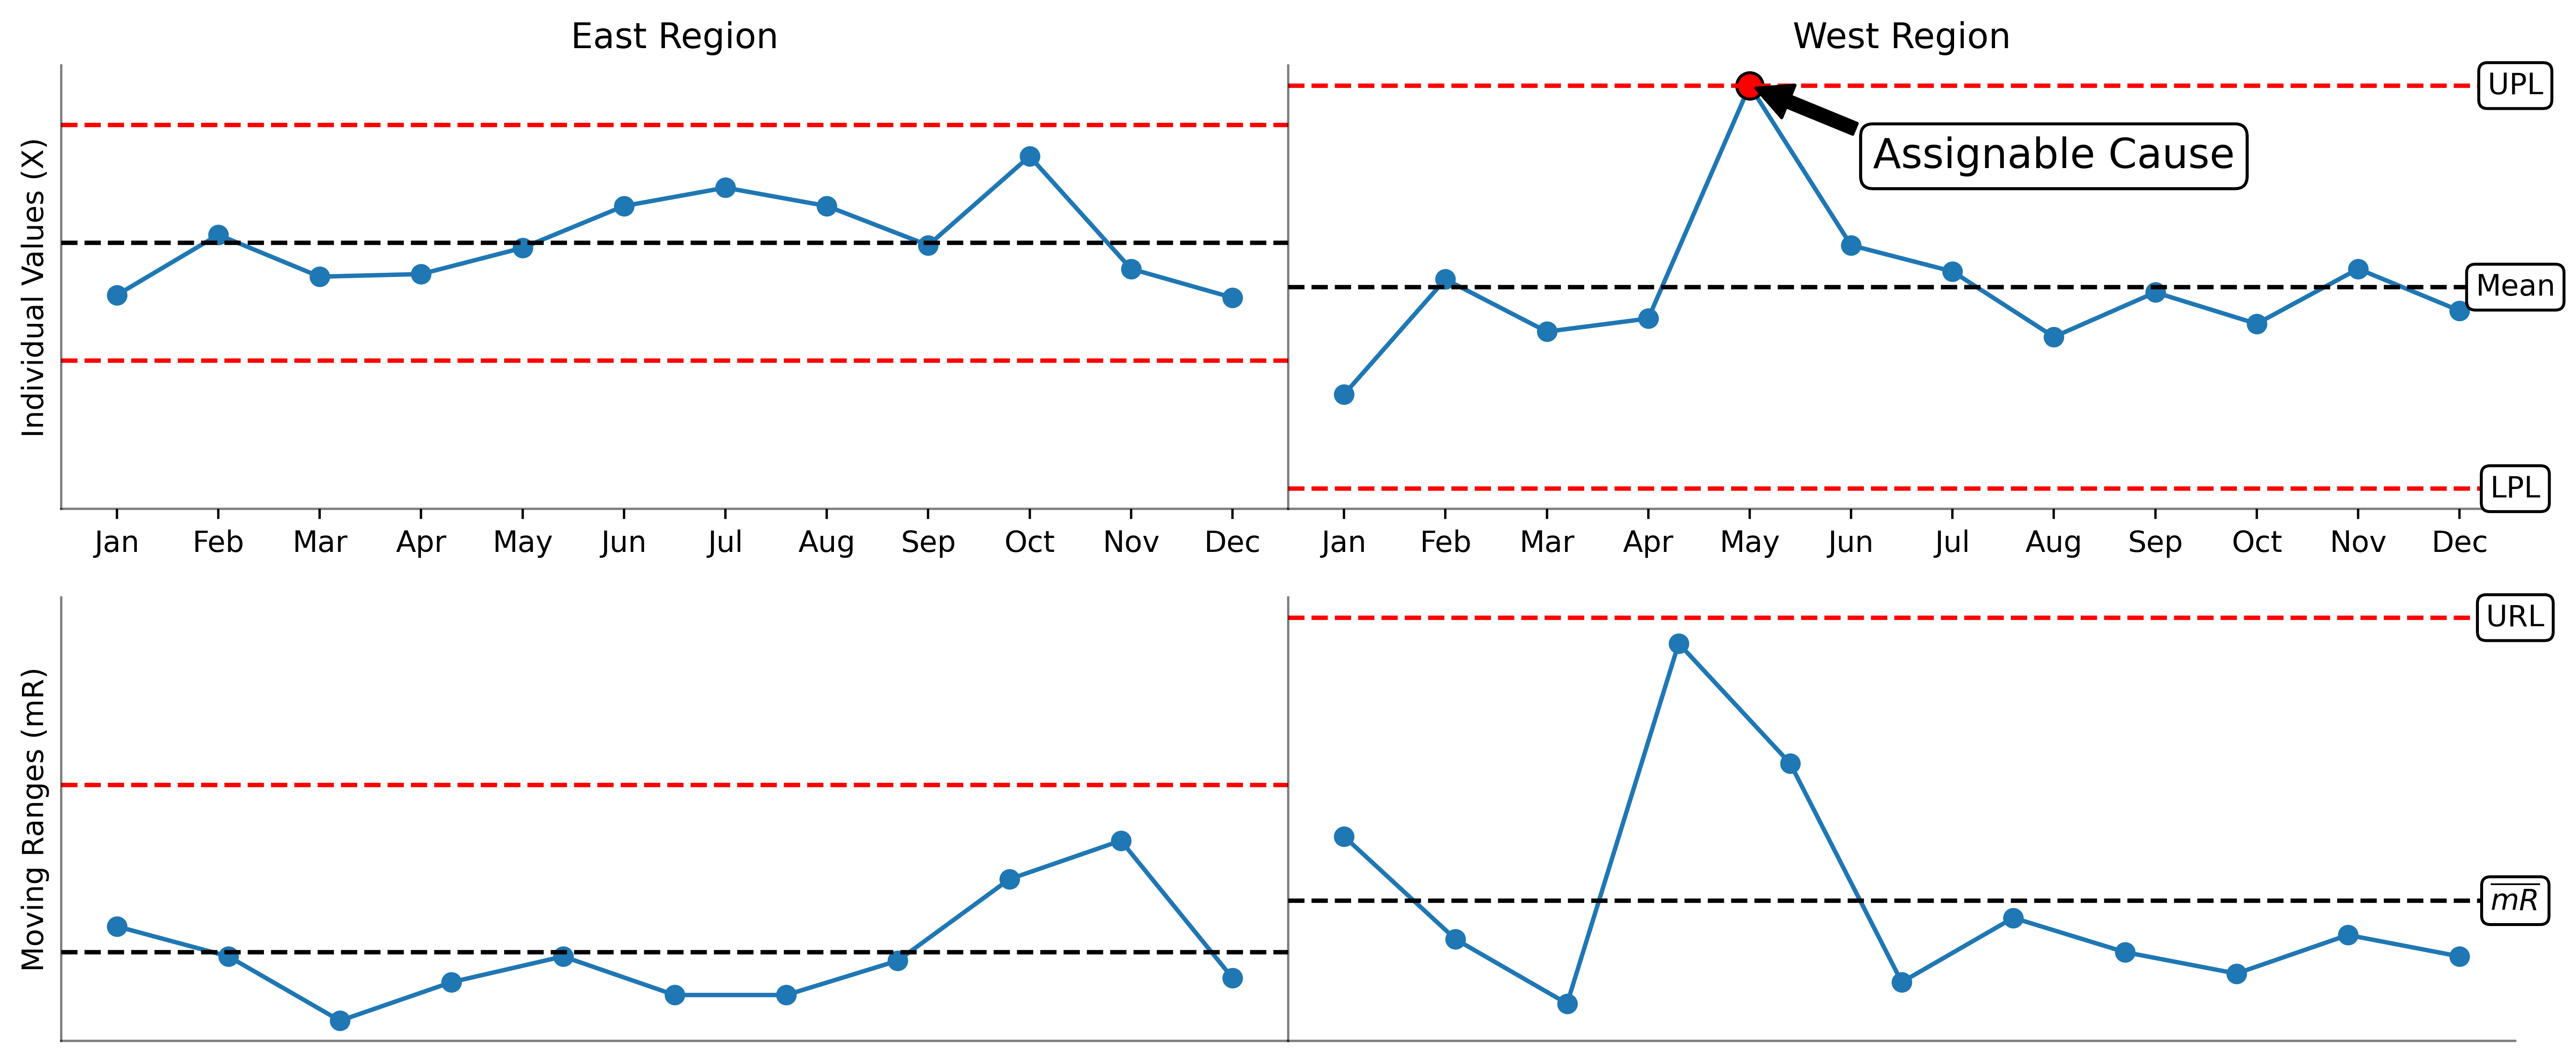

In [34]:
# Specify round_value
round_value = 1
# Specify condition
condition = 'Sales'
xtick_labels = 'Month'

# Define plotting parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), dpi=500, sharey='row')
plt.subplots_adjust(wspace=0)

# Initialize an empty list to store stats for each dataframe
stats_list = []

# Loop through the df_list and plot on the axes
for idx, (df, label) in enumerate(zip(df_list, plot_label_names)):

    data = df[condition]
    moving_range = round(abs(data.diff()), round_value)
    xticks = df[xtick_labels]

    # Specify scaling factors
    C1 = 2.660
    C2 = 3.268

    # Calculate statistics for UPL and LPL
    mean = round(data.mean(), round_value)
    average_mR = round(moving_range.mean(), round_value)
    UPL = round(mean + (C1 * average_mR), round_value)
    LPL = round(max(mean - (C1 * average_mR), 0), round_value)
    URL = round(C2 * average_mR, round_value)

    # Characterize process
    if ((data < LPL) | (data > UPL)).any():
        characterization = "Unpredictable"
    elif (moving_range > URL).any():  # Add condition for moving range exceeding the URL
        characterization = "Unpredictable"
    else:
        characterization = "Predictable"

    # Store statistics in the list
    stats_list.append({
        'Label': label,
        'Mean': mean,
        'Ave. mR': average_mR,
        'UPL': UPL,
        'LPL': LPL,
        'URL': URL,
        'PRL': UPL-LPL,
        'Characterization': characterization
    })

    # Plot individual values in the first two subplots (top row)
    axes[0, idx].plot(data, marker='o')
    # Masking and plotting limits
    axes[0, idx].plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].set_title(label)

    # Add UPL and LPL horizontal lines for individual values plot
    axes[0, idx].axhline(UPL, color='red', linestyle='--')
    axes[0, idx].axhline(LPL, color='red', linestyle='--')
    axes[0, idx].axhline(mean, color='black', linestyle='--')
    
    # Set x-tick labels with separate intervals
    tick_positions = np.arange(0, len(xticks), 1)
        
    axes[0, idx].set_xticks(tick_positions)
    axes[0, idx].set_xticklabels(xticks.iloc[tick_positions], rotation=0, ha='center')

    # Plot moving range in the second row
    axes[1, idx].plot(moving_range, marker='o')

    # Add UPL and LPL horizontal lines for moving range plot
    axes[1, idx].axhline(URL, color='red', linestyle='--')
    axes[1, idx].axhline(average_mR, color='black', linestyle='--')
    axes[1, idx].plot(np.ma.masked_where(moving_range < URL, moving_range), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Add label to y-axes
    axes[0, 0].set_ylabel('Individual Values (X)')
    axes[1, 0].set_ylabel('Moving Ranges (mR)')
    
    # Remove yticks
    axes[0, 0].set_yticks([])
    axes[1, 0].set_yticks([])
    
    # Establish bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

    # Add labels to 2nd and 4th plots
    if idx == 1:
        axes[0, idx].text(axes[0, idx].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], mean, 'Mean', color='black', ha='center', va='center', bbox=bbox_props)

    if idx == 1:
        axes[1, idx].text(axes[1, idx].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', bbox=bbox_props)
        axes[1, idx].text(axes[1, idx].get_xlim()[1], average_mR, r'$\overline{mR}$', 
                          color='black', ha='center', va='center', bbox=bbox_props)

    # Add annotations
    axes[0,1].annotate('Assignable Cause', 
         xy=(4,18.7),  # x, y coordinates of the annotation
         xytext=(7,16),  # Position of the text
         fontsize=14,
         color='black',
         ha='center',
         va='center',
         arrowprops=dict(facecolor='black', shrink=0.05),
         bbox=dict(facecolor='white',boxstyle='round',edgecolor='black'))

    # Remove ticks on xticks for moving ranges
    axes[1, idx].set_xticks([])
    
    # Loop through the axes and set spine width
    for ax_row in axes:
        for ax in ax_row:
            for spine in ax.spines.values():
                spine.set_alpha(0.5)

# Stylize plots
sns.despine()
    
# Convert stats list into DataFrame
stats_df = pd.DataFrame(stats_list)

## Fig 17.8: XmR Chart of death-to-birth ratios as Vienna General

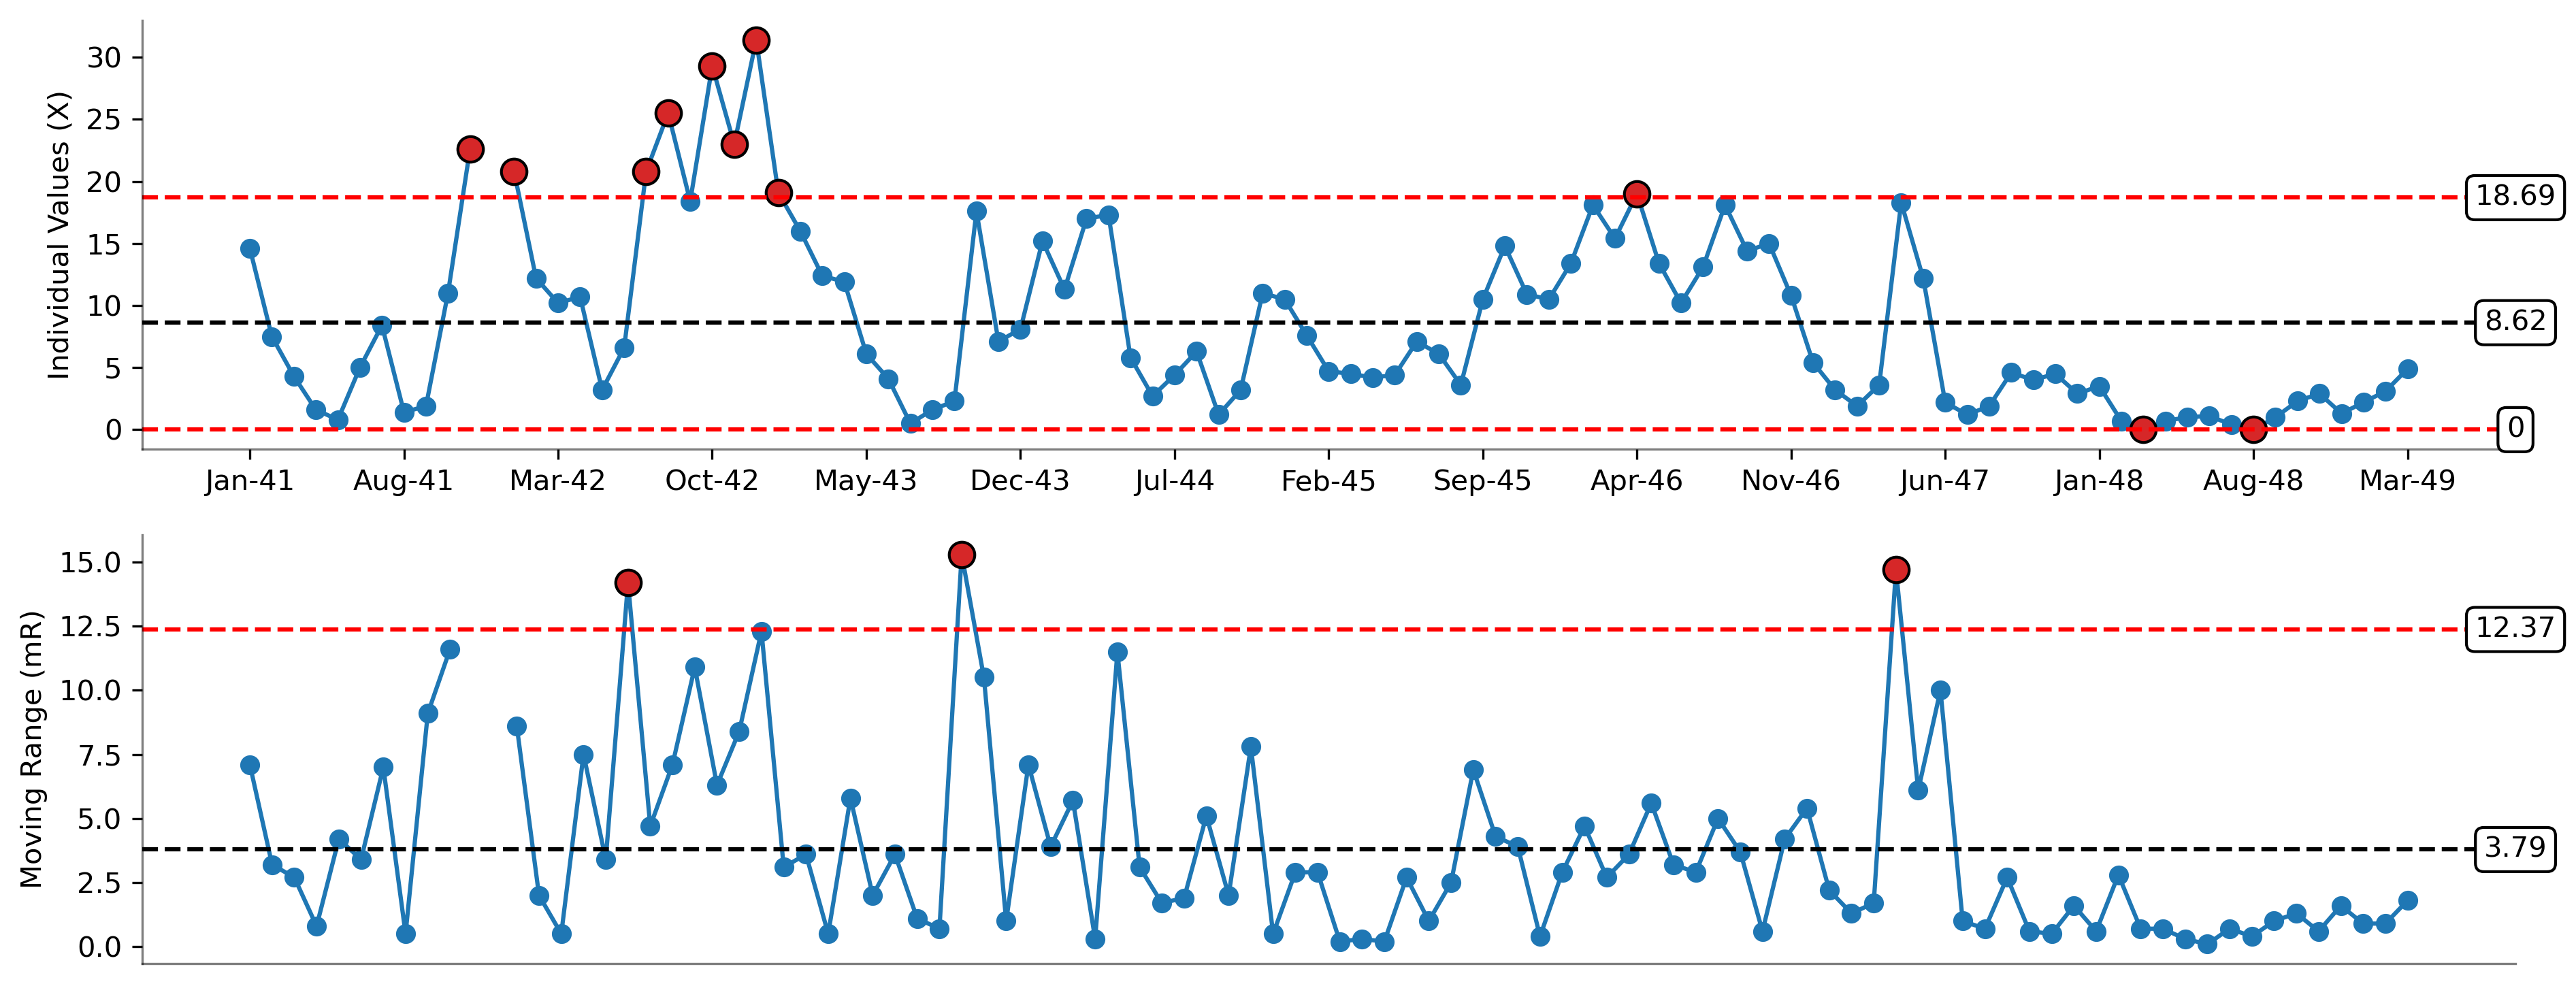

In [63]:
# Round setting
round_value = 2

# Extract Data
data = vienna_df['Death-to-Birth Ratio']
labels = vienna_df['ShortMonthYear']
moving_ranges = vienna_df['Moving Ranges']

# Calculate statistics
mean = data.mean()
average_mR = moving_ranges.mean()
# Calculate the process limits
C1 = 2.660
C2 = 3.268

UPL = round(mean + (C1*average_mR),round_value)
LPL = max(0,round(mean - (C1*average_mR),round_value))
URL = round((C2*average_mR),round_value)

# Define Process Limits
xchart_lines = [(mean, 'black'), (UPL, 'red'), (LPL, 'red')]
mrchart_lines = [(average_mR, 'black'), (URL, 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Setup Figure
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1, dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color in xchart_lines:
    axs[0].axhline(value, ls='--', c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1] * 1.0, value, round(value, round_value),
                color='black', ha='center', va='center', bbox=bbox_props)

# X-Axis Formatting
tick_interval = 7
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_ranges, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color in mrchart_lines:
    axs[1].axhline(value, ls='--', c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1] * 1.0, value, round(value, round_value),
                color='black', ha='center', va='center', bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel("Individual Values (X)")
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)")

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Show Plot
plt.show()

## 17.9: XmR Chart with annotation

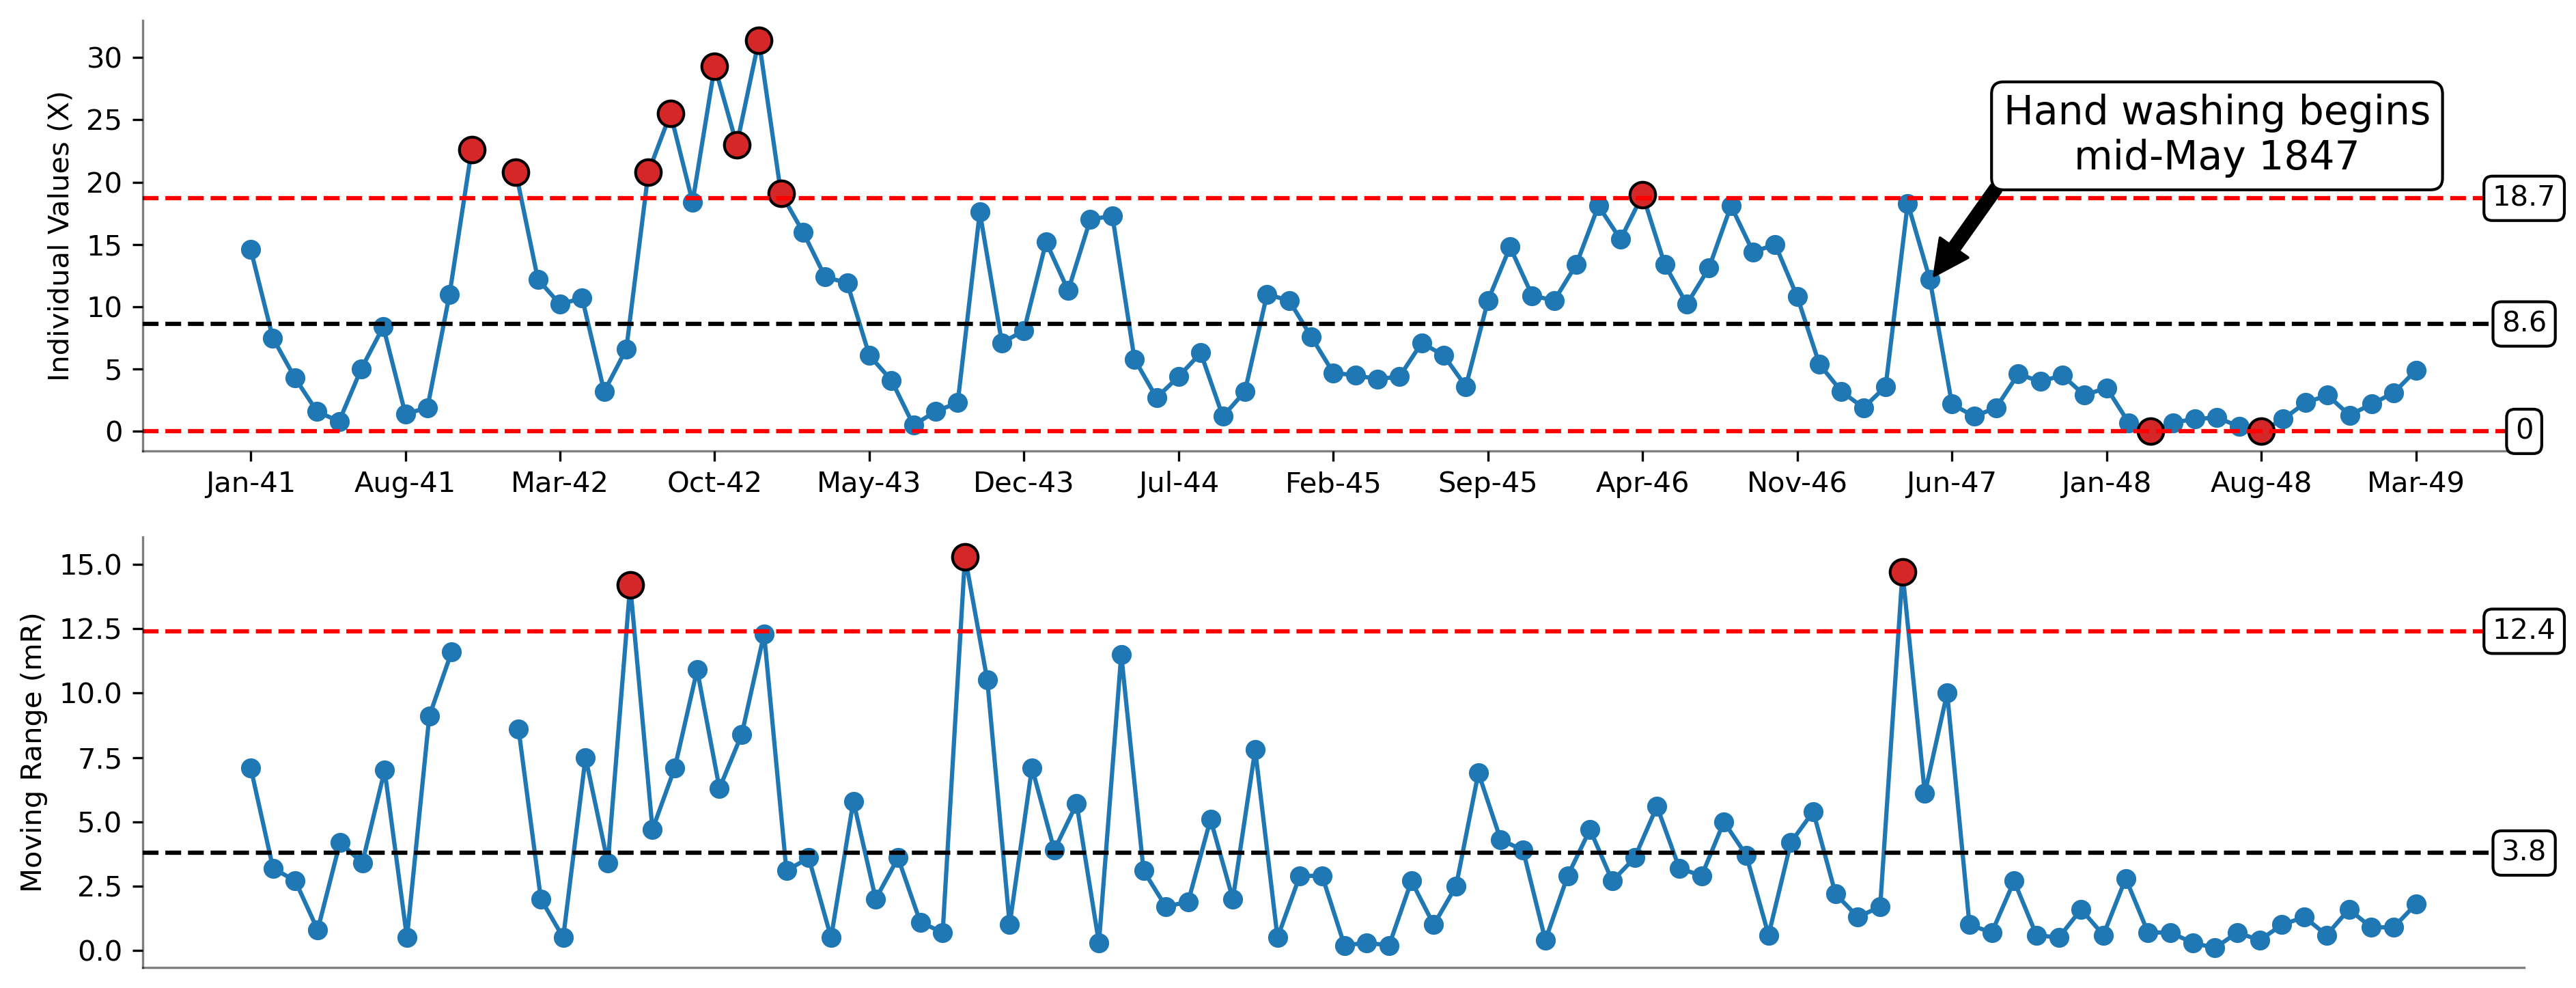

In [64]:
# Round setting
round_value = 1

# Extract Data
data = vienna_df['Death-to-Birth Ratio']
labels = vienna_df['ShortMonthYear']
moving_ranges = vienna_df['Moving Ranges']

# Calculate statistics
mean = data.mean()
average_mR = moving_ranges.mean()
# Calculate the process limits
C1 = 2.660
C2 = 3.268

UPL = round(mean + (C1*average_mR),round_value)
LPL = max(0,round(mean - (C1*average_mR),round_value))
URL = round((C2*average_mR),round_value)

# Define Process Limits
xchart_lines = [(mean, 'black'), (UPL, 'red'), (LPL, 'red')]
mrchart_lines = [(average_mR, 'black'), (URL, 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Setup Figure
fig, axs = plt.subplots(figsize=(15, 6), nrows=2, ncols=1, dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color in xchart_lines:
    axs[0].axhline(value, ls='--', c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1] * 1.0, value, round(value, round_value),
                color='black', ha='center', va='center', bbox=bbox_props)

# X-Axis Formatting
tick_interval = 7
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_ranges, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color in mrchart_lines:
    axs[1].axhline(value, ls='--', c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1] * 1.0, value, round(value, round_value),
                color='black', ha='center', va='center', bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel("Individual Values (X)")
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)")

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Add arrow to highlight May-1847
axs[0].annotate('Hand washing begins\nmid-May 1847', 
             xy=(76.2,12.5), 
             xytext=(89,21), 
             color='black', 
             fontsize=14,
             ha='center',
             arrowprops=dict(facecolor='black'),
             bbox=dict(facecolor='white',boxstyle='round',edgecolor='black'))
    
# Show Plot
plt.show()

## Fig 17.10: XmR Chart comparison before hand washing vs after hand washing

In [67]:
# Create before and after hand washing dataframes
vienna_df.tail(25)

,MonthYear,Year,Month,Births,Deaths,Death-to-Birth Ratio,Moving Ranges,ShortMonthYear
74,March 1847,1847,March,305.0,11.0,3.6,1.7,Mar-47
75,April 1847,1847,April,312.0,57.0,18.3,14.7,Apr-47
76,May 1847,1847,May,294.0,36.0,12.2,6.1,May-47
77,June 1847,1847,June,268.0,6.0,2.2,10.0,Jun-47
78,July 1847,1847,July,250.0,3.0,1.2,1.0,Jul-47
79,August 1847,1847,August,264.0,5.0,1.9,0.7,Aug-47
80,September 1847,1847,September,262.0,12.0,4.6,2.7,Sep-47
81,October 1847,1847,October,278.0,11.0,4.0,0.6,Oct-47
82,November 1847,1847,November,246.0,11.0,4.5,0.5,Nov-47
83,December 1847,1847,December,273.0,8.0,2.9,1.6,Dec-47


In [113]:
before_df = vienna_df.iloc[:77]
after_df = vienna_df.iloc[77:].reset_index(drop=True).drop(columns='Moving Ranges')
# Recaclulate 'Moving Ranges'
after_df['Moving Ranges'] = abs(after_df['Death-to-Birth Ratio'].diff())
after_df

,MonthYear,Year,Month,Births,Deaths,Death-to-Birth Ratio,ShortMonthYear,Moving Ranges
0,June 1847,1847,June,268.0,6.0,2.2,Jun-47,NaN
1,July 1847,1847,July,250.0,3.0,1.2,Jul-47,1.0
2,August 1847,1847,August,264.0,5.0,1.9,Aug-47,0.7
3,September 1847,1847,September,262.0,12.0,4.6,Sep-47,2.7
4,October 1847,1847,October,278.0,11.0,4.0,Oct-47,0.6
5,November 1847,1847,November,246.0,11.0,4.5,Nov-47,0.5
6,December 1847,1847,December,273.0,8.0,2.9,Dec-47,1.6
7,January 1848,1848,January,283.0,10.0,3.5,Jan-48,0.6
8,February 1848,1848,February,291.0,2.0,0.7,Feb-48,2.8
9,March 1848,1848,March,276.0,0.0,0.0,Mar-48,0.7


In [114]:
df_list = [before_df, after_df]
plot_label_names = ['Before hand washing', 'After hand washing']

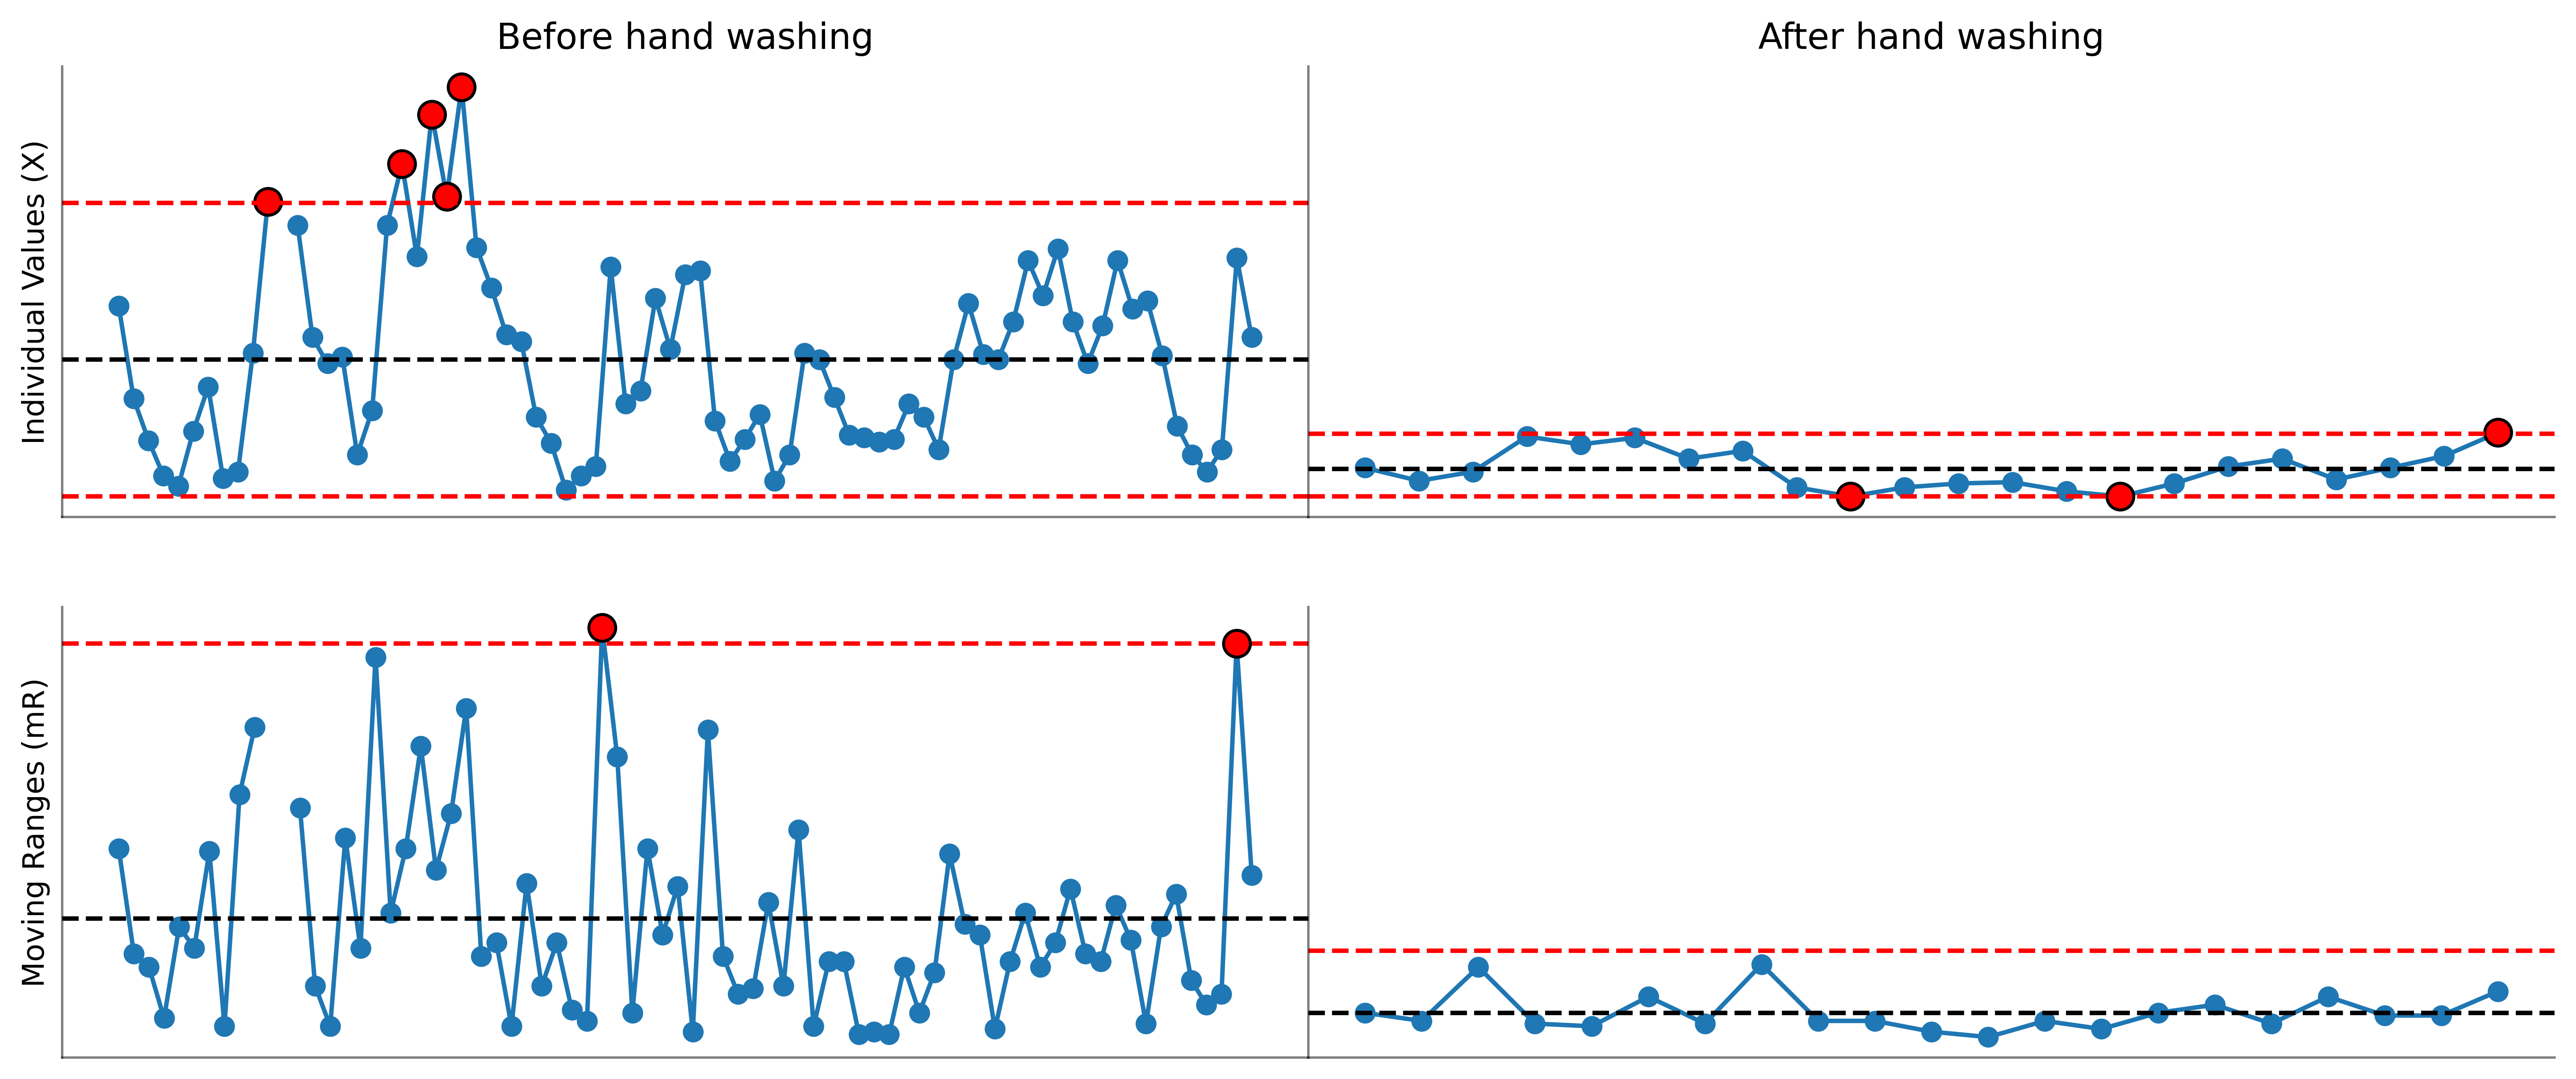

In [115]:
# Specify round_value
round_value = 1
# Specify tick interval
tickinterval = 5

show_limit_labels=False

# Specify condition
condition = 'Death-to-Birth Ratio'
xtick_labels = 'ShortMonthYear'

# Define plotting parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6), dpi=500, sharey='row')
plt.subplots_adjust(wspace=0)

# Initialize an empty list to store stats for each dataframe
stats_list = []

# Loop through the df_list and plot on the axes
for idx, (df, label) in enumerate(zip(df_list, plot_label_names)):

    data = df[condition]
    moving_range = round(abs(data.diff()), round_value)
    xticks = df[xtick_labels]

    # Specify scaling factors
    C1 = 2.660
    C2 = 3.268

    # Calculate statistics for UPL and LPL
    mean = round(data.mean(), round_value)
    average_mR = round(moving_range.mean(), round_value)
    UPL = round(mean + (C1 * average_mR), round_value)
    LPL = round(max(mean - (C1 * average_mR), 0), round_value)
    URL = round(C2 * average_mR, round_value)

    # Characterize process
    if ((data < LPL) | (data > UPL)).any():
        characterization = "Unpredictable"
    elif (moving_range > URL).any():  # Add condition for moving range exceeding the URL
        characterization = "Unpredictable"
    else:
        characterization = "Predictable"

    # Store statistics in the list
    stats_list.append({
        'Label': label,
        'Mean': mean,
        'Ave. mR': average_mR,
        'UPL': UPL,
        'LPL': LPL,
        'URL': URL,
        'PRL': UPL-LPL,
        'Characterization': characterization
    })

    # Plot individual values in the first two subplots (top row)
    axes[0, idx].plot(data, marker='o')
    # Masking and plotting limits
    axes[0, idx].plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].set_title(label)

    # Add UPL and LPL horizontal lines for individual values plot
    axes[0, idx].axhline(UPL, color='red', linestyle='--')
    axes[0, idx].axhline(LPL, color='red', linestyle='--')
    axes[0, idx].axhline(mean, color='black', linestyle='--')
    
    # Set x-tick labels with separate intervals
    tick_positions = np.arange(0, len(xticks), tickinterval)
        
    axes[0, idx].set_xticks(tick_positions)
    axes[0, idx].set_xticklabels(xticks.iloc[tick_positions], rotation=0, ha='center')

    # Plot moving range in the second row
    axes[1, idx].plot(moving_range, marker='o')

    # Add UPL and LPL horizontal lines for moving range plot
    axes[1, idx].axhline(URL, color='red', linestyle='--')
    axes[1, idx].axhline(average_mR, color='black', linestyle='--')
    axes[1, idx].plot(np.ma.masked_where(moving_range < URL, moving_range), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Add label to y-axes
    axes[0, 0].set_ylabel('Individual Values (X)')
    axes[1, 0].set_ylabel('Moving Ranges (mR)')
    
    # Remove yticks
    axes[0, 0].set_yticks([])
    axes[1, 0].set_yticks([])
    
    # Establish bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
    
    if show_limit_labels:
        # Add labels to 2nd and 4th plots
        if idx == 1:
            axes[0, idx].text(axes[0, idx].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center', bbox=bbox_props)
            axes[0, idx].text(axes[0, idx].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', bbox=bbox_props)
            axes[0, idx].text(axes[0, idx].get_xlim()[1], mean, 'Mean', color='black', ha='center', va='center', bbox=bbox_props)

        if idx == 1:
            axes[1, idx].text(axes[1, idx].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', bbox=bbox_props)
            axes[1, idx].text(axes[1, idx].get_xlim()[1], average_mR, r'$\overline{mR}$', 
                              color='black', ha='center', va='center', bbox=bbox_props)

    # Remove ticks on xticks for moving ranges
    axes[0, idx].set_xticks([])
    axes[1, idx].set_xticks([])
    
    
    # Loop through the axes and set spine width
    for ax_row in axes:
        for ax in ax_row:
            for spine in ax.spines.values():
                spine.set_alpha(0.5)

# Stylize plots
sns.despine()
    
# Convert stats list into DataFrame
stats_df = pd.DataFrame(stats_list)

## Fig 17.11: XmR Chart for after hand washing

In [116]:
after_df

,MonthYear,Year,Month,Births,Deaths,Death-to-Birth Ratio,ShortMonthYear,Moving Ranges
0,June 1847,1847,June,268.0,6.0,2.2,Jun-47,NaN
1,July 1847,1847,July,250.0,3.0,1.2,Jul-47,1.0
2,August 1847,1847,August,264.0,5.0,1.9,Aug-47,0.7
3,September 1847,1847,September,262.0,12.0,4.6,Sep-47,2.7
4,October 1847,1847,October,278.0,11.0,4.0,Oct-47,0.6
5,November 1847,1847,November,246.0,11.0,4.5,Nov-47,0.5
6,December 1847,1847,December,273.0,8.0,2.9,Dec-47,1.6
7,January 1848,1848,January,283.0,10.0,3.5,Jan-48,0.6
8,February 1848,1848,February,291.0,2.0,0.7,Feb-48,2.8
9,March 1848,1848,March,276.0,0.0,0.0,Mar-48,0.7


In [117]:
C2 = 3.268
moving_ranges = after_df['Moving Ranges']
average_mR = moving_ranges.mean()
URL = C2*average_mR
URL

3.3458095238095233

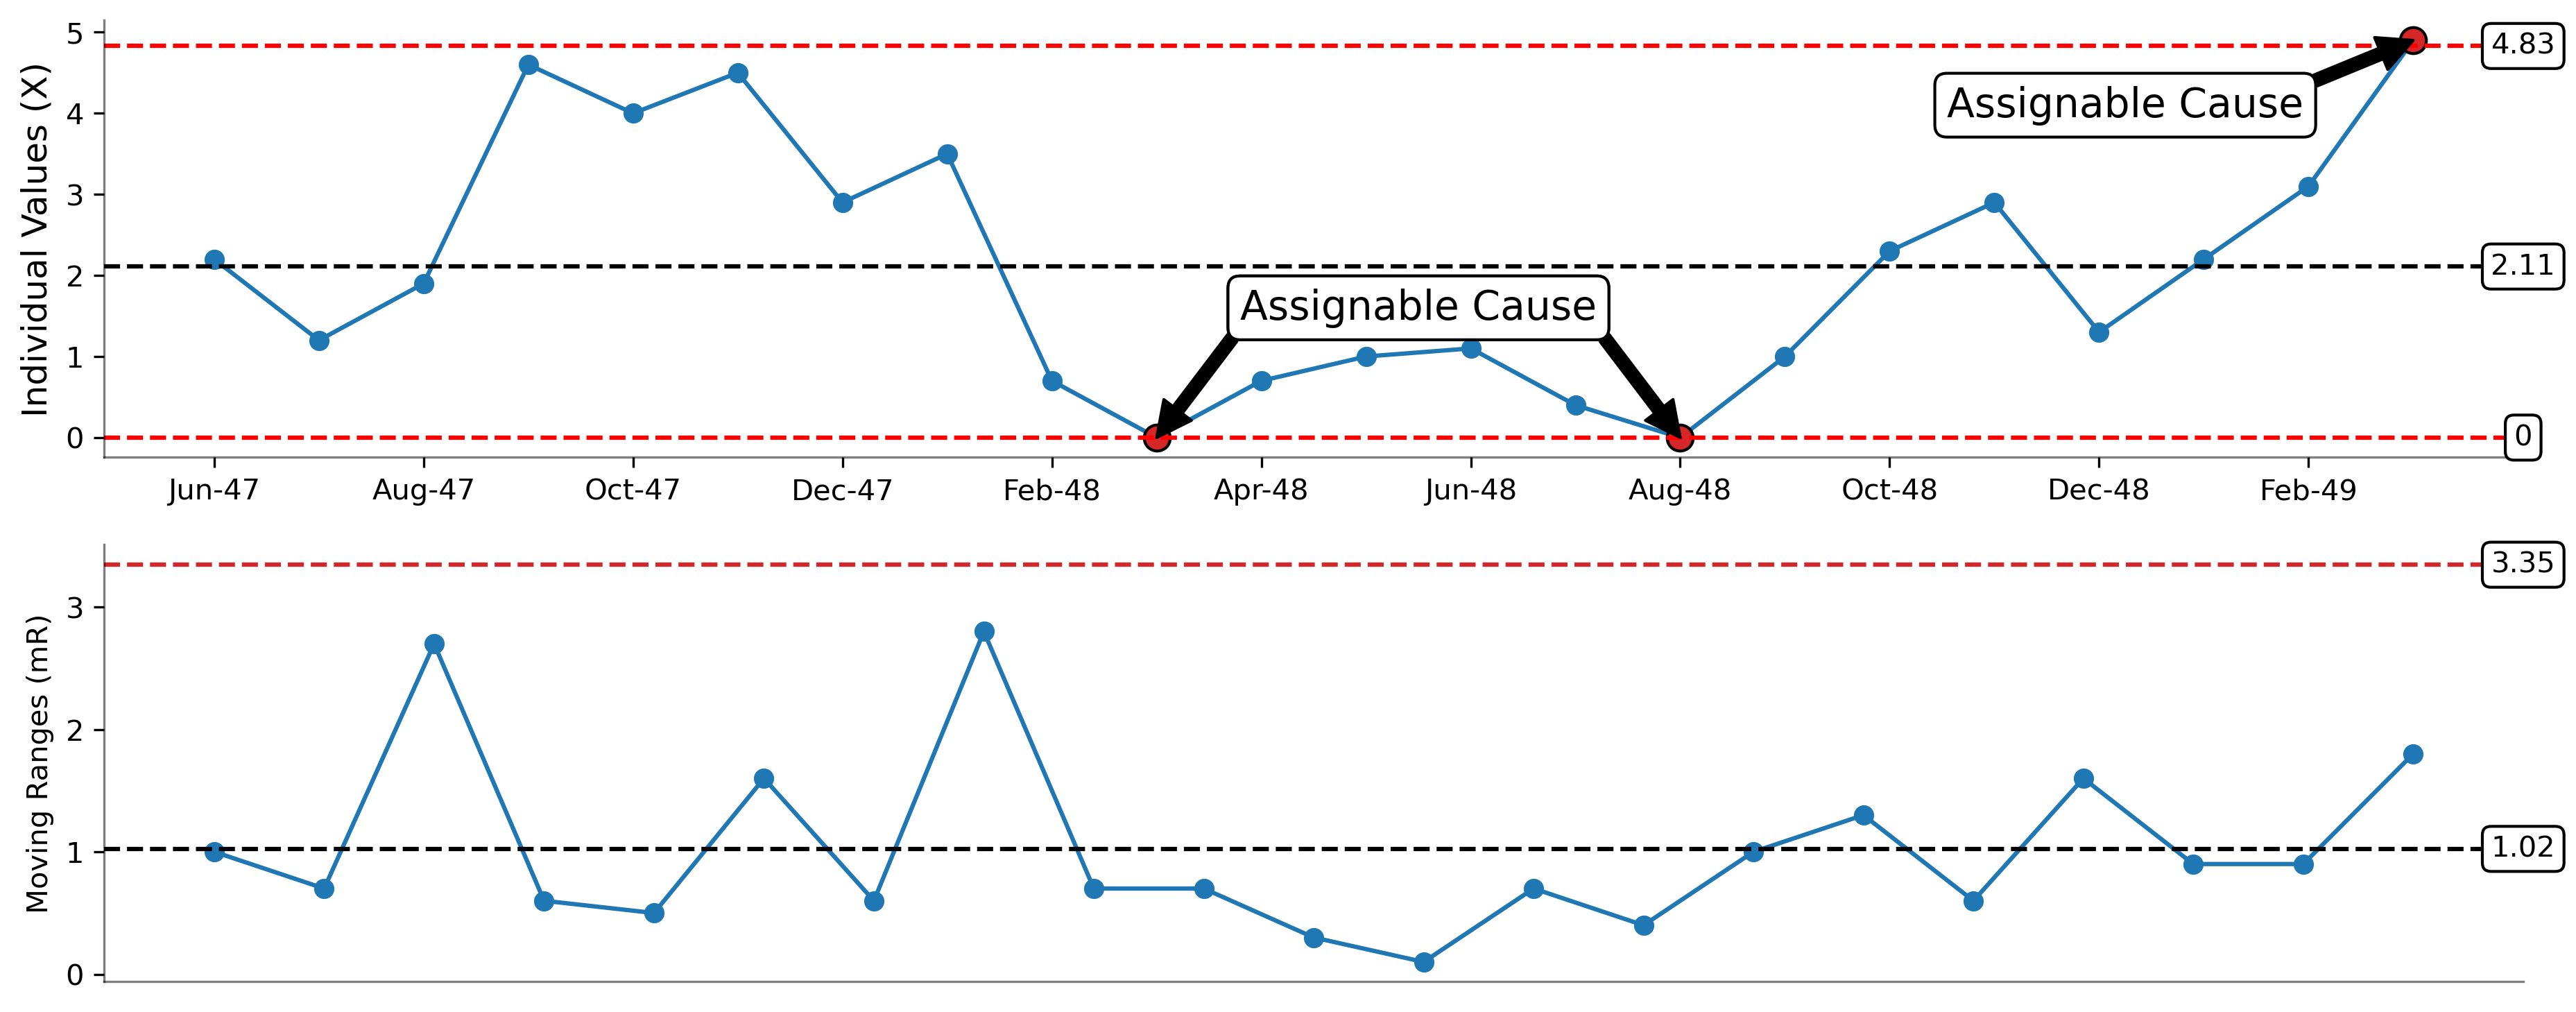

In [127]:
# Specify tickinterval
tickinterval = 2
round_value = 2
# Disaggregate the dataframe 
data = after_df["Death-to-Birth Ratio"]
moving_ranges = after_df['Moving Ranges']
labels = after_df["ShortMonthYear"]

C1 = 2.660
C2 = 3.268

mean = round(data.mean(),2)
average_mR = moving_ranges.mean()

UPL = round(mean + (C1*average_mR),2)
LPL = max(0,mean - (C1*average_mR))
URL = C2*average_mR

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]
mrchart_lines = [(average_mR,'black'), (URL,'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Generate the X-chart
fig, axs = plt.subplots(figsize=(15,6), nrows=2, ncols=1, dpi=300)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, UPL, color='black', ha='center', va='center', bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, LPL, color='black', ha='center', va='center', bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], mean, mean, color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in xchart_lines:
    axs[0].axhline(value, ls='--', c=color)

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Individual Values (X)", fontsize=12)
axs[0].set_title("", fontsize=14)

# Define details for annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Assignable Cause', (9,0),(11.5,1.6)),
    ('Assignable Cause', (14,0),(11.5,1.6)),
    ('Assignable Cause', (21, 4.9),(18.25, 4.1))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    axs[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black'))

# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')

axs[1].axhline(URL, ls='--', c='tab:red')
axs[1].axhline(average_mR, ls='--', c='black')

axs[1].text(axs[1].get_xlim()[1], URL, round(URL,2), color='black', ha='center', va='center', bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], average_mR, round(average_mR,2), color='black', ha='center', va='center', bbox=bbox_props)

# Remove xticks on mR chart
axs[1].set_xticks([])
axs[1].set_ylabel('Moving Ranges (mR)')

# Despine 
sns.despine()
for value in range(0,2):
    axs[value].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

## Fig 17.12: After hand washing additional annotations

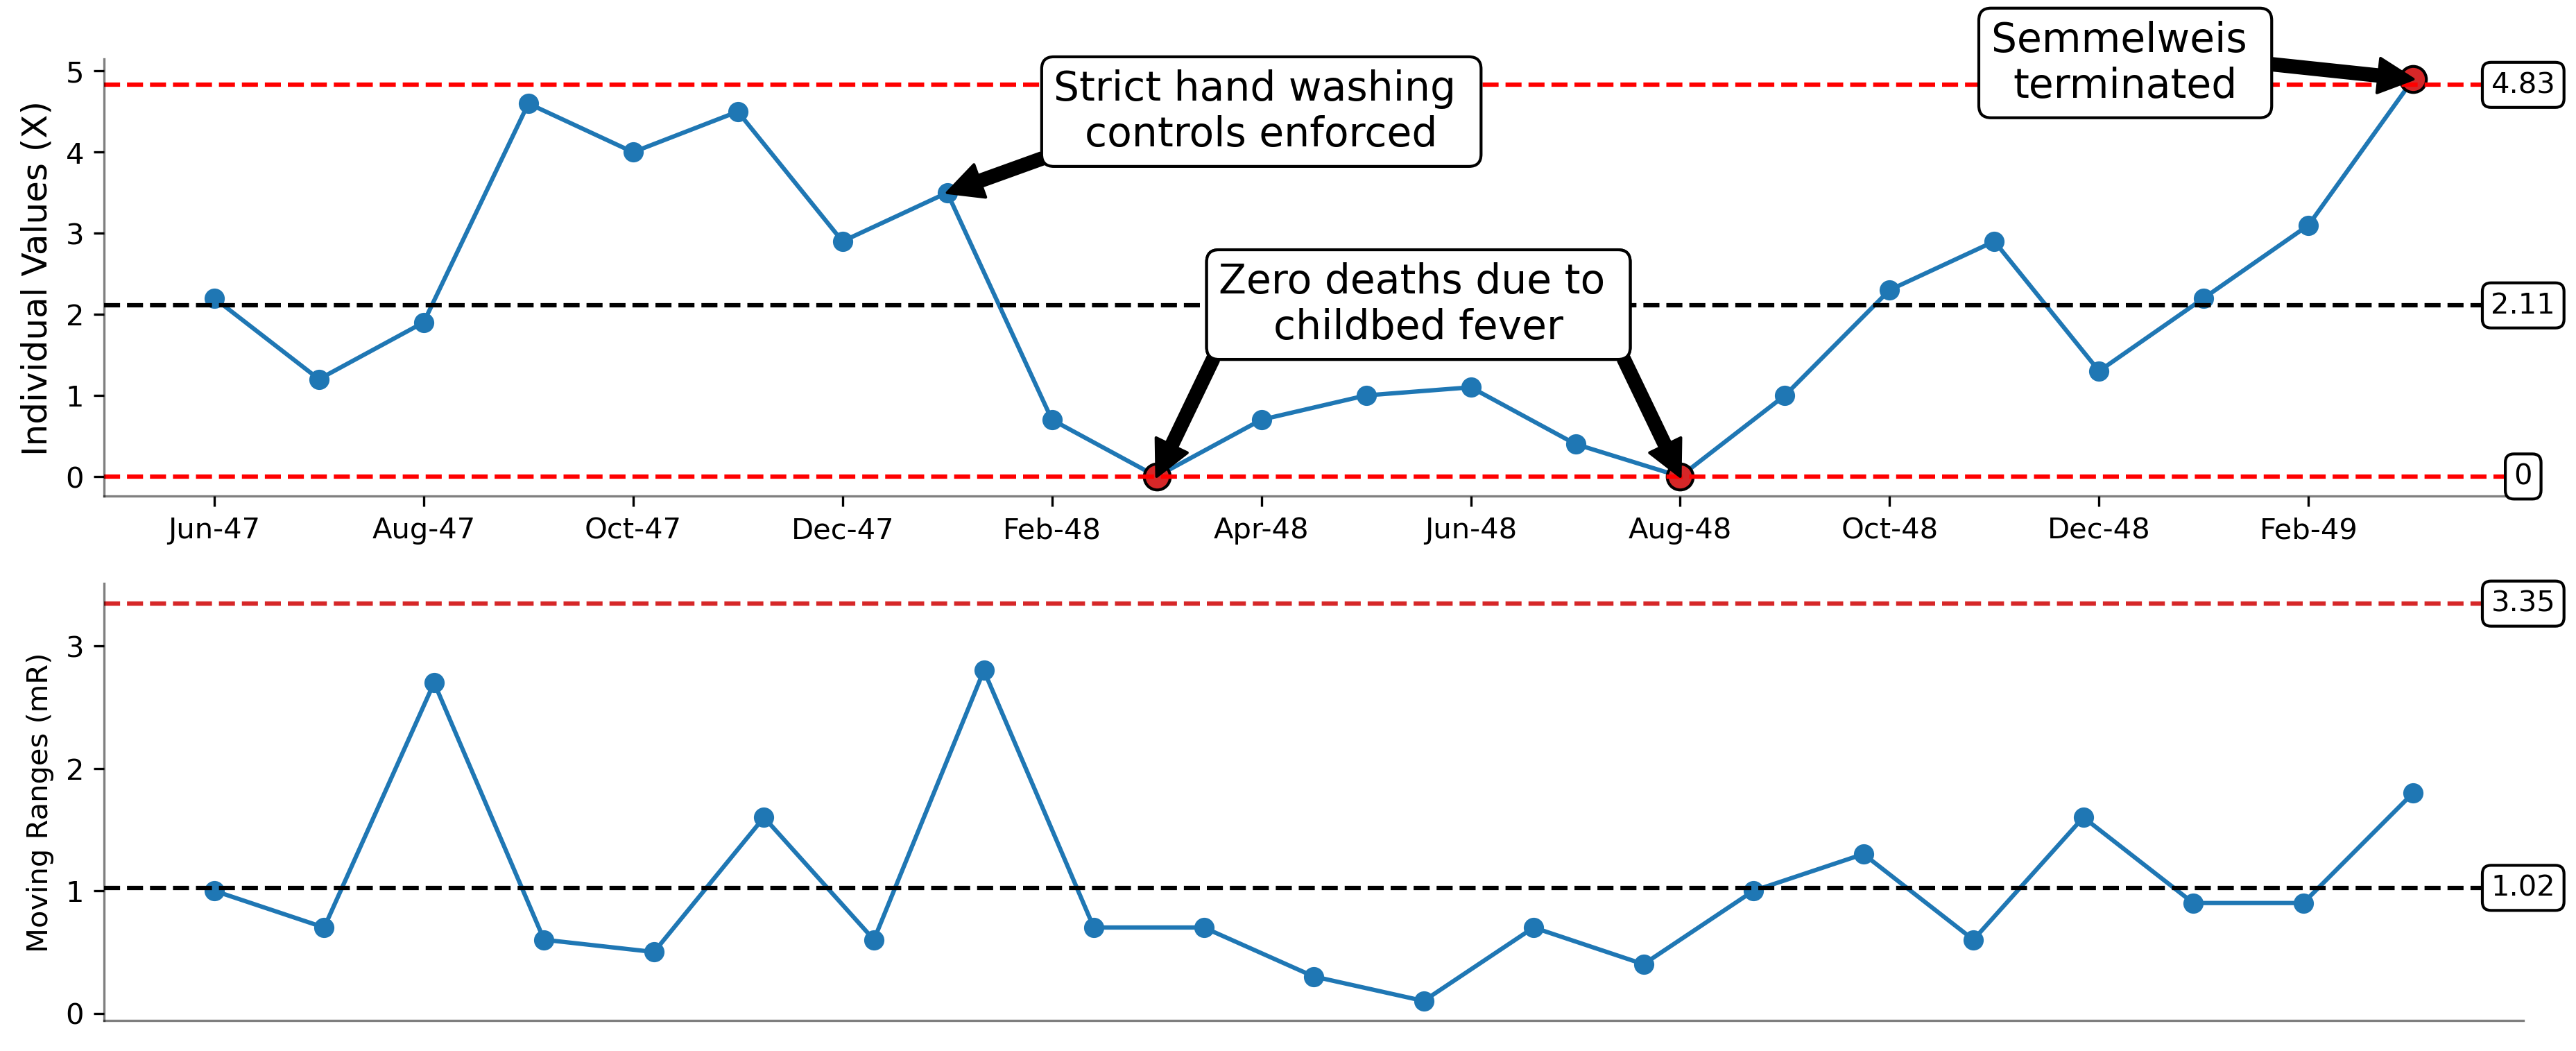

In [136]:
# Specify tickinterval
tickinterval = 2
round_value = 2
# Disaggregate the dataframe 
data = after_df["Death-to-Birth Ratio"]
moving_ranges = after_df['Moving Ranges']
labels = after_df["ShortMonthYear"]

C1 = 2.660
C2 = 3.268

mean = round(data.mean(),2)
average_mR = moving_ranges.mean()

UPL = round(mean + (C1*average_mR),2)
LPL = max(0,mean - (C1*average_mR))
URL = C2*average_mR

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > URL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]
mrchart_lines = [(average_mR,'black'), (URL,'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
mrchart_labels = [(URL,URL),(average_mR,average_mR)]

# Generate the X-chart
fig, axs = plt.subplots(figsize=(15,6), nrows=2, ncols=1, dpi=300)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
axs[0].text(axs[0].get_xlim()[1], UPL, UPL, color='black', ha='center', va='center', bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], LPL, LPL, color='black', ha='center', va='center', bbox=bbox_props)
axs[0].text(axs[0].get_xlim()[1], mean, mean, color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in xchart_lines:
    axs[0].axhline(value, ls='--', c=color)

# # Set the x-tick labels with increased intervals
tick_interval = tickinterval  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Individual Values (X)", fontsize=12)
axs[0].set_title("", fontsize=14)

# Define details for annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('Strict hand washing \ncontrols enforced', (7,3.5),(10.,4.5)),
    ('Zero deaths due to \nchildbed fever', (9,0),(11.5,2.12)),
    ('Zero deaths due to \nchildbed fever', (14,0),(11.5,2.12)),
    ('Semmelweis \nterminated', (21, 4.9),(18.25, 5.1))
]

# Add annotations using a loop
for text, xy, xytext in annotations:
    axs[0].annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black')) 
    
# Plot moving ranges
axs[1].plot(labels, moving_ranges, marker='o')

axs[1].axhline(URL, ls='--', c='tab:red')
axs[1].axhline(average_mR, ls='--', c='black')

axs[1].text(axs[1].get_xlim()[1], URL, round(URL,2), color='black', ha='center', va='center', bbox=bbox_props)
axs[1].text(axs[1].get_xlim()[1], average_mR, round(average_mR,2), color='black', ha='center', va='center', bbox=bbox_props)

# Remove xticks on mR chart
axs[1].set_xticks([])
axs[1].set_ylabel('Moving Ranges (mR)')

# Despine 
sns.despine()
for value in range(0,2):
    axs[value].spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()